In [1]:
import datetime
import os
import json
import re
from functools import partial
from itertools import count, filterfalse

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from gensim.models import word2vec
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer

Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #2.
Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #3.


### dump and load

In [2]:
# logger
def initialize_logger(dirpath='./output/pipeline'):
    dirname = datetime.datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
    os.makedirs(os.path.join(dirpath, dirname), exist_ok=True)
    
    def logger(filename, obj):    
        filepath = os.path.join(dirpath, dirname, filename)
        _, ext = os.path.splitext(filename)
        if ext == '.npy':
            np.save(filepath, obj)
        elif ext == '.json':
            json.dump(obj, open(filepath, 'w'), indent=4, ensure_ascii=False)
        else :
            raise Exception

    return logger

In [3]:
# loader
def load_log(timestamp, filename, dirpath='./output/pipeline'):
    filepath = os.path.join(dirpath, timestamp, filename)
    
    _, ext = os.path.splitext(filename)
    if ext == '.npy':
        return np.load(filepath)
    elif ext == '.json':
        return json.load(open(filepath, 'r'))
    else :
        raise Exception

### preprocessing

In [4]:
import pandas as pd
from itertools import count


input_train='./aozora_datasets_min/train_author_novel.csv'
df_train = pd.read_csv(input_train)
filename_author_map = dict(zip(df_train.filename, df_train.author_name))
author_label_map = dict(zip(set(df_train.author_name), count())) 

In [5]:
import glob, os


train_files = glob.glob('./aozora_datasets_min/train_datasets/*.txt')
train_filenames = list(map(os.path.basename, train_files)) # doesnt reproduce result when iter is consumed
train_authors = list(map(filename_author_map.get, train_filenames))

In [6]:
y = np.array(list(map(author_label_map.get, train_authors)))
y

array([ 4,  0, 16, ..., 15, 10, 10])

In [7]:
y.shape

(1589,)

In [8]:
import MeCab
import pandas as pd
import re
# from mojimoji import han_to_zen, zen_to_han
import numpy as np
from collections import Counter
from functools import partial, reduce
from itertools import chain, count, filterfalse, repeat
from operator import countOf, itemgetter, methodcaller

compose = lambda *funcs: reduce(lambda f, g: lambda *args, **kwargs: f(g(*args, **kwargs)), funcs)
flip = lambda f: lambda *args: f(*args[::-1])
pipe = flip(compose)


# str -> list
split_text_into_lines = methodcaller('splitlines')
# str -> str
convert_text_to_lowercase = methodcaller('lower')
# str -> str
replace_whitespace_with_blank_char = partial(re.sub, "\s", " ")
# str -> str
remove_whitespace = partial(re.sub, "\s", "")
# str -> str
strip_multiple_blank_chars_to_one = partial(re.sub, " +", " ")
# str -> str
strip_consecutive_chars_to_one = lambda char='ー': partial(re.sub, '{}+'.format(char), '{}'.format(char))

# str -> str
def insert_text_between_blank_chars(text, patterns):
    repls = map(" {} ".format, patterns)
    for pattern, repl in zip(patterns, repls):
        text = text.replace(pattern, repl)
    return text

# str -> str
def remove_whitespace_between_japanese_chars(text):
    """
    """
    chars = "[、。〃々〆〇ぁ-んゔゝゞァ-ンヴヵヶ・ーヽヾ一-龥]"
    pattern = "(?<={chars})\s+(?={chars})".format(chars=chars)
    repl = ""
    return re.sub(pattern, repl, text)

# str -> list
parse_tab_separated_text = re.compile("\t").split
noisy_symbols = list('!"#$%&\'()*+,-./:;<=>?@[]^_`{|}¢£¥§¨¬°±´¶×÷‐―‖"†‡‥…‰′″※℃Å←↑→↓⇒⇔∀∂∃∇∈∋−√∝∞∠∧∨∩∪∫∬∴∵∽≒≠≡≦≧≪≫⊂⊃⊆⊇⊥⌒─━│┃┌┏┐┓└┗┘┛├┝┠┣┤┥┨┫┬┯┰┳┴┷┸┻┼┿╂╋■□▲△▼▽◆◇○◎●◯★☆♀♂♪♭♯＃〈〉《》「」『』【】〒〓〔〕〜゛゜・＼／｀￣（）。、”’｀？！［］')

def maybe_lemmatize(mecab_node):
    for surface, feature in map(re.compile('\t').split, mecab_node.splitlines()[:-1]):
        if len(feature.split(',')) == 7:
            yield surface
        else:
            yield feature.split(',')[6]

def remove_noisy_symbols(raw_tokens):
    remove = dict.fromkeys(noisy_symbols, True).get
    return filterfalse(remove, raw_tokens)

preprocess = pipe(
    str,
#     han_to_zen,
#     partial(zen_to_han, kana=False),
    convert_text_to_lowercase,
    replace_whitespace_with_blank_char,
    remove_whitespace_between_japanese_chars,
    strip_consecutive_chars_to_one(),
    partial(insert_text_between_blank_chars, patterns=noisy_symbols),
    strip_multiple_blank_chars_to_one,
#     partial(re.sub, '\d', '0'),
    MeCab.Tagger().parse,
    maybe_lemmatize,
    remove_noisy_symbols,
    list
)


def tokenize_ja(path):
    with open(path) as f:
        lines = f.readlines()
        lines = [preprocess(line) for line in lines] 
        return list(chain.from_iterable(lines))

In [47]:
data = pd.DataFrame(columns=['author', 'tokens'])

In [48]:
data['author'] = train_authors

In [52]:
data['tokens'] = [tokenize_ja(path) for path in train_files]

In [53]:
data

,author,tokens
0,江戸川 乱歩,"[空, とぶ, 円盤, 空, とぶ, 円盤, は, 中, 見出し, 空, とぶ, 円盤, は..."
1,折口 信夫,"[一, 飛鳥, の, 都, 以後, 奈良, 朝, 以前, の, 感情, 生活, の, 記録,..."
2,中谷 宇吉郎,"[六, 華, 豊年, の, 兆, という, 言葉, が, ある, 位, 雪, の, 結晶, ..."
3,坂本 竜馬,"[扨, も, 人間, の, 一世, ひと, よ, ハ, がてん, がてん, に, 合点, の..."
4,岡本 綺堂,"[一, 秋, の, 夜, の, 長い, 頃, だ, ある, た, わたし, が, 例, の,..."
...,...,...
1584,岡本 綺堂,"[餅, を, 買う, 女, 小夜, の, 中山, の, 夜, 泣石, の, 伝説, も, 支..."
1585,中谷 宇吉郎,"[サントリー, の, 鳥井, 信, 治郎, さん, と, は, もう, 三, 十, 年, 越..."
1586,吉川 英治,"[７, 字, 下げ, 一, 一, は, 中, 見出し, 笛, は, 孤独, だ, たのしめる..."
1587,紫式部,"[地, から, ３, 字, 上げ, 皮, ごろ, も, 上, に, 着る, たり, ば, 我..."


In [57]:
data.loc[data.isnull().any(axis=1)]

,author,tokens


In [10]:
# dump preprocessed data

corpus_tokenized_ja = data['tokens'].tolist()
logger = initialize_logger()
logger('corpus_tokenized_ja.json', corpus_tokenized_ja)

NameError: name 'data' is not defined

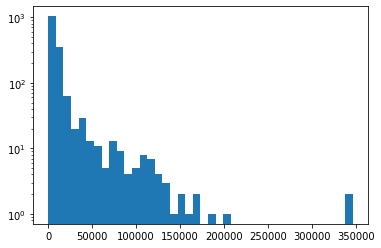

In [9]:
# overview japanese corpus
import matplotlib.pyplot as plt

corpus_tokenized_ja = load_log('20200208T072910Z','corpus_tokenized_ja.json')
len_tokens_ja = list(map(len, corpus_tokenized_ja))
plt.hist(len_tokens_ja, bins=40)
plt.yscale('log')

In [10]:
len(corpus_tokenized_ja)

1589

### vectorize

In [44]:
# get word vectors by gensim
def build_word_embedding_vectors(corpus_tokenized, word2vec_parameters):
    model = word2vec.Word2Vec(corpus_tokenized, **word2vec_parameters)
    return model.wv.vectors, model.wv.index2word

In [45]:
# culster word vectors by GMM
def culster_embedding_vectors(word_embeddings, gmm_parameters) -> np.ndarray:
    X = word_embeddings
    gm = GaussianMixture(**gmm_parameters)
    gm.fit(X)
    return gm.predict_proba(X)

In [46]:
# TF-IDF takes 20 min
# Use for Japanese
from collections import Counter
from itertools import chain, repeat
from operator import countOf


def build_tfidf_selfmade(corpus, vocab):
    countup = lambda doc: list(map(countOf, repeat(doc), vocab))
    tf = np.array(list(map(countup, corpus)))
    idf = np.log(len(corpus) / (tf > 0).sum(axis=0)) + 1
    return tf, idf, tf*idf

In [47]:
# TF-IDF
# cannot be used for JApanese
from sklearn.feature_extraction.text import TfidfVectorizer

def build_tfidf_sklearn(corpus_tokenized, vocab):
    tfv = TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b', strip_accents='unicode', dtype=np.float64)
    tfv.fit(list(map(' '.join, corpus_tokenized)))
    feature_names = tfv.get_feature_names()
    idf = tfv._tfidf.idf_
    print(len(feature_names), len(idf), len(vocab))
    return np.fromiter(map(dict(zip(feature_names, idf)).get, vocab), dtype='f8')    

In [48]:
def build_word_topic_vector(word_embedding_vectors, word_cluster_probabilities, idf_vector):
    wcv = np.einsum('ij,ik->ijk', word_embedding_vectors, word_cluster_probabilities).reshape(word_embedding_vectors.shape[0], -1)
    return np.einsum('i,ij->ij', idf_vector, wcv)

In [49]:
# document vectors
def count(i=0):
    while True:
        yield i
        i+=1

def normalize_document_vectors(dv: np.ndarray) -> np.ndarray:
    dv_sum = np.square(dv).sum(axis=1)
    dv_l2norm = np.sqrt(dv_sum)
    return np.einsum('ij,i->ij', dv, 1.0/dv_l2norm)

def build_document_vectors(vocabulary, corpus_tokenized, word_topic_vectors):
    vocabulary_idx_map = dict(zip(vocabulary, count()))
    
    document_vecotrs = []
    for doc in corpus_tokenized:
        doc_idx = list(filter(lambda idx: idx is not None, map(vocabulary_idx_map.get, doc)))
        document_vecotrs.append(np.einsum('ij->j',word_topic_vectors[doc_idx]))
    
    return normalize_document_vectors(np.array(document_vecotrs))

In [50]:
# SCDV
def make_sparse(document_vectors, param):
    t = 0.5 * (np.abs(np.min(document_vectors, axis=1).mean()) + np.abs(np.max(document_vectors, axis=1).mean()))
    sparsity_threshold = param * t
    mask = np.abs(document_vectors) < sparsity_threshold
    return np.where(mask, 0.0, document_vectors)

In [51]:
word2vec_parameters = {
    'size':200,   # Word vector dimensionality
    'min_count':20,    # Minimum word count
    'workers':40,    # Number of threads to run in parallel
    'window':10,    # Context window size
    'sample':1e-3,    # Downsample setting for frequent words
    'hs':0,
    'sg':1,
    'negative':10,
    'iter':25,
    'seed':1
}

word_embedding_vectors, vocabulary = build_word_embedding_vectors(corpus_tokenized_ja, word2vec_parameters)

NameError: name 'corpus_tokenized_ja' is not defined

In [18]:
logger = initialize_logger()
logger('word_embedding_vectors.npy', word_embedding_vectors)
logger('vocabulary.json', vocabulary)

NameError: name 'word_embedding_vectors' is not defined

In [19]:
timestamp = '20200211T051316Z'
word_embedding_vectors = load_log(timestamp,'word_embedding_vectors.npy')
vocabulary = load_log(timestamp,'vocabulary.json')
word_embedding_vectors.shape, len(vocabulary)

((30639, 200), 30639)

In [20]:
gmm_parameters = {
    'n_components':60,
    'random_state':42,
    'covariance_type':'tied',
    'init_params':'kmeans',
    'max_iter':50
}

word_cluster_probability_matrix = culster_embedding_vectors(word_embedding_vectors, gmm_parameters)

In [21]:
logger = initialize_logger()
logger('word_cluster_probabilities.npy', word_cluster_probability_matrix)

In [23]:
timestamp = '20200211T065328Z'
word_cluster_probability_matrix = load_log(timestamp,'word_cluster_probabilities.npy')
word_cluster_probability_matrix.shape

(30639, 60)

In [24]:
# tf, idf, tfidf = build_tfidf_selfmade(corpus_tokenized_ja, vocabulary)

In [26]:
# logger = initialize_logger()
# logger('tf_matrix.npy', tf)
# logger('idf_vector.npy', idf)
# logger('tfidf_matrix.npy', tfidf)

In [24]:
tf_matrix = load_log('20200209T192435Z','tf_matrix.npy')
idf_vector = load_log('20200209T192435Z','idf_vector.npy')
tfidf_matrix = load_log('20200209T192435Z','tfidf_matrix.npy')

In [25]:
tf_matrix.shape, idf_vector.shape, tfidf_matrix.shape

((1589, 30639), (30639,), (1589, 30639))

In [26]:
word_topic_vectors = build_word_topic_vector(word_embedding_vectors, word_cluster_probability_matrix, idf_vector)
document_vectors = build_document_vectors(vocabulary, corpus_tokenized_ja, word_topic_vectors)
param = 0.04
scdv = make_sparse(document_vectors, param)

In [28]:
# logger = initialize_logger()
logger('scdv.npy', scdv)

In [29]:
timestamp = '20200211T065328Z'
scdv = load_log(timestamp,'scdv.npy')
scdv.shape

(1589, 12000)

### classification validation with SCDV

In [32]:
X = scdv
X.shape, y.shape

((1589, 12000), (1589,))

In [49]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=None, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [36]:
n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for test_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    y_test = y[test_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred)
    accuracy_train.append(bas)
    
    y_pred = clf.predict(X_test)
    bas = balanced_accuracy_score(y_test, y_pred)
    accuracy_test.append(bas)

accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

In [37]:
accuracy_train

array([1., 1., 1., 1., 1.])

In [38]:
accuracy_test

array([0.89537489, 0.89033353, 0.89159108, 0.91264606, 0.93791923])

In [39]:
np.average(accuracy_test)

0.9055729602537724

### classification validation with TF-IDF

In [41]:
X = tfidf_matrix
X.shape, y.shape

((1589, 30639), (1589,))

In [17]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=None, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [44]:
n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for test_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    y_test = y[test_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred)
    accuracy_train.append(bas)
    
    y_pred = clf.predict(X_test)
    bas = balanced_accuracy_score(y_test, y_pred)
    accuracy_test.append(bas)

accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

In [45]:
accuracy_train

array([1., 1., 1., 1., 1.])

In [46]:
accuracy_test

array([0.88052853, 0.87864139, 0.85111964, 0.88744406, 0.87213309])

In [47]:
np.average(accuracy_test)

0.8739733401432732

## predict test data

### preprocess

In [26]:
import glob, os


test_files = glob.glob('./aozora_datasets_min/test_datasets/*.txt')

In [25]:
test_files

['./aozora_datasets_min/test_datasets/54740.txt',
 './aozora_datasets_min/test_datasets/56321.txt',
 './aozora_datasets_min/test_datasets/56201.txt',
 './aozora_datasets_min/test_datasets/51417.txt',
 './aozora_datasets_min/test_datasets/49540.txt',
 './aozora_datasets_min/test_datasets/46139.txt',
 './aozora_datasets_min/test_datasets/1711.txt',
 './aozora_datasets_min/test_datasets/3578.txt',
 './aozora_datasets_min/test_datasets/51959.txt',
 './aozora_datasets_min/test_datasets/56210.txt',
 './aozora_datasets_min/test_datasets/42172.txt',
 './aozora_datasets_min/test_datasets/46630.txt',
 './aozora_datasets_min/test_datasets/46331.txt',
 './aozora_datasets_min/test_datasets/43473.txt',
 './aozora_datasets_min/test_datasets/57350.txt',
 './aozora_datasets_min/test_datasets/33225.txt',
 './aozora_datasets_min/test_datasets/46070.txt',
 './aozora_datasets_min/test_datasets/53215.txt',
 './aozora_datasets_min/test_datasets/56544.txt',
 './aozora_datasets_min/test_datasets/54756.txt',
 '

In [30]:
author_label_map.get(filename_author_map.get('54739.txt'))

3

In [41]:
# dump preprocessed data

corpus_tokenized_ja_test = data_test['tokens'].tolist()
logger = initialize_logger()
logger('corpus_tokenized_ja_test.json', corpus_tokenized_ja_test)

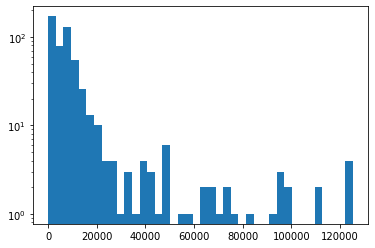

In [11]:
# overview japanese corpus
import matplotlib.pyplot as plt


corpus_tokenized_ja_test = load_log('20200213T135503Z','corpus_tokenized_ja_test.json')
len_tokens_ja = list(map(len, corpus_tokenized_ja_test))
plt.hist(len_tokens_ja, bins=40)
plt.yscale('log')

In [33]:
data_test = pd.DataFrame(columns=['filename','tokens'])
# data_test['tokens'] = [tokenize_ja(path) for path in test_files]

In [35]:
data_test['filename'] = list(map(os.path.basename, test_files))

In [37]:
data_test['tokens'] = corpus_tokenized_ja_test

In [38]:
# Nan check

data_test.loc[data_test.isnull().any(axis=1)]

,filename,tokens


In [39]:
data_test

,filename,tokens
0,54740.txt,"[９, 字, 下げ, 一, 一, は, 中, 見出し, 日本一, の, 面白い, 話, が,..."
1,56321.txt,"[５, 字, 下げ, 一, 一, は, 中, 見出し, 捕物, 小説, という, もの, を..."
2,56201.txt,"[５, 字, 下げ, 一, 一, は, 中, 見出し, おや, 八, 五, 郎, 親分, も..."
3,51417.txt,"[先刻, 御, 面, 遠い, 遠い, に, 倒, の, 注記, 御, 頼, 申, 上, 候,..."
4,49540.txt,"[何, と, いう, て, も, この, 頃, は, 読書, 子, に, 取る, て, は,..."
...,...,...
527,476.txt,"[一, 次郎左衛門, じ, ろ, ざえもん, が, 野, 州, や, しゅう, 佐野, の,..."
528,57308.txt,"[今年, の, 六月, 本土, 爆撃, が, いよいよ, 苛烈, に, なる, て, 東京,..."
529,1710.txt,"[序, 思想, という, もの, は, その, 持ち主, の, 身, に, つく, ば, そ..."
530,53489.txt,"[もう, 十, 年, 以上, も, 前, の, こと, だ, ある, が, まだ, 私, が..."


### vectorize

In [52]:
word2vec_parameters = {
    'size':200,   # Word vector dimensionality
    'min_count':20,    # Minimum word count
    'workers':40,    # Number of threads to run in parallel
    'window':10,    # Context window size
    'sample':1e-3,    # Downsample setting for frequent words
    'hs':0,
    'sg':1,
    'negative':10,
    'iter':25,
    'seed':1
}

word_embedding_vectors, vocabulary = build_word_embedding_vectors(corpus_tokenized_ja_test, word2vec_parameters)

In [53]:
logger('word_embedding_vectors.npy', word_embedding_vectors)
logger('vocabulary.json', vocabulary)

In [54]:
timestamp = '20200213T135503Z'
word_embedding_vectors = load_log(timestamp,'word_embedding_vectors.npy')
vocabulary = load_log(timestamp,'vocabulary.json')
word_embedding_vectors.shape, len(vocabulary)

((15353, 200), 15353)

In [55]:
gmm_parameters = {
    'n_components':60,
    'random_state':42,
    'covariance_type':'tied',
    'init_params':'kmeans',
    'max_iter':50
}

word_cluster_probability_matrix = culster_embedding_vectors(word_embedding_vectors, gmm_parameters)

In [56]:
logger('word_cluster_probabilities.npy', word_cluster_probability_matrix)

In [57]:
timestamp = '20200213T135503Z'
word_cluster_probability_matrix = load_log(timestamp,'word_cluster_probabilities.npy')
word_cluster_probability_matrix.shape

(15353, 60)

In [58]:
tf, idf, tfidf = build_tfidf_selfmade(corpus_tokenized_ja_test, vocabulary)

In [59]:
# logger = initialize_logger()
logger('tf_matrix.npy', tf)
logger('idf_vector.npy', idf)
logger('tfidf_matrix.npy', tfidf)

In [60]:
timestamp = '20200213T135503Z'
tf_matrix = load_log(timestamp,'tf_matrix.npy')
idf_vector = load_log(timestamp,'idf_vector.npy')
tfidf_matrix = load_log(timestamp,'tfidf_matrix.npy')

In [61]:
tf_matrix.shape, idf_vector.shape, tfidf_matrix.shape

((532, 15353), (15353,), (532, 15353))

In [62]:
word_topic_vectors = build_word_topic_vector(word_embedding_vectors, word_cluster_probability_matrix, idf_vector)
document_vectors = build_document_vectors(vocabulary, corpus_tokenized_ja_test, word_topic_vectors)
param = 0.04
scdv = make_sparse(document_vectors, param)

In [63]:
# logger = initialize_logger()
logger('scdv.npy', scdv)

In [59]:
timestamp = '20200213T135503Z'
scdv = load_log(timestamp,'scdv.npy')
scdv.shape

(532, 12000)

In [60]:
X_test = scdv

### train classifier with training data

In [40]:
timestamp = '20200211T065328Z'
X_train = load_log(timestamp,'scdv.npy')
X_train.shape

(1589, 12000)

In [41]:
y_train = y

In [42]:
y_train.shape

(1589,)

<BarContainer object of 17 artists>

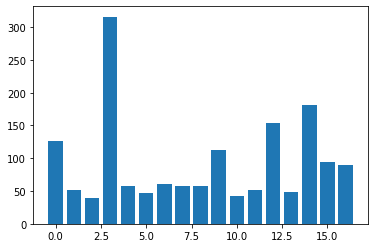

In [45]:
u, counts = np.unique(y_train, return_counts=True)
plt.bar(u, counts)

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=5, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [131]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [132]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [133]:
# inspect prediction for validation sets

X, y = X_train, y_train

n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for val_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    y_val = y[val_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred_train)
    print(bas)
    
    y_pred_val = clf.predict(X_val)
    bas = balanced_accuracy_score(y_val, y_pred_val)
    print(bas)
    
    break

0.9063431672967143
0.7449781475733034


<BarContainer object of 17 artists>

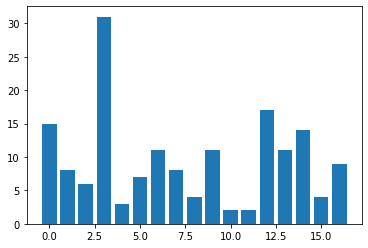

In [134]:
u, counts = np.unique(y_pred_val, return_counts=True)
plt.bar(u, counts)

### predict test label and set author names

(array([382.,  51.,  30.,  13.,   9.,  11.,  15.,   4.,   7.,   3.,   0.,
          2.,   1.,   0.,   0.,   2.,   0.,   0.,   1.,   1.]),
 array([0.08960149, 0.09772012, 0.10583874, 0.11395737, 0.12207599,
        0.13019462, 0.13831324, 0.14643187, 0.15455049, 0.16266912,
        0.17078774, 0.17890637, 0.18702499, 0.19514362, 0.20326224,
        0.21138087, 0.21949949, 0.22761812, 0.23573675, 0.24385537,
        0.251974  ]),
 <a list of 20 Patch objects>)

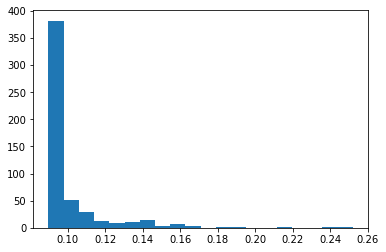

In [135]:
y_pred_proba = clf.predict_proba(X_test)
plt.hist(list(map(max, y_pred_proba)), bins=20)
# plt.hist(y_pred_proba.max(axis=1), bins=20)

In [139]:
y_pred = y_pred_proba.argmax(axis=1)

In [141]:
y_pred

array([0, 9, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 9, 0, 2, 9, 1, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,
       0, 1, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 1, 0, 9, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 9,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 9, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 3, 9, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 2, 0, 9, 3, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 0, 3, 3, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 1, 0, 0, 0, 0, 3, 3, 1, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0,

<BarContainer object of 5 artists>

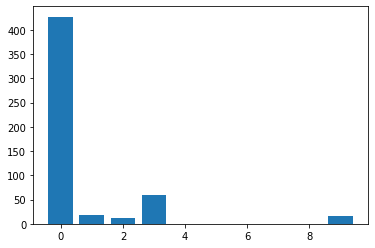

In [140]:
u, counts = np.unique(y_pred, return_counts=True)
plt.bar(u, counts)

In [129]:
list(range(17))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [61]:
y_pred = clf.predict(X_test)

In [63]:
len(y_pred), len(X_test)

(532, 532)

<BarContainer object of 13 artists>

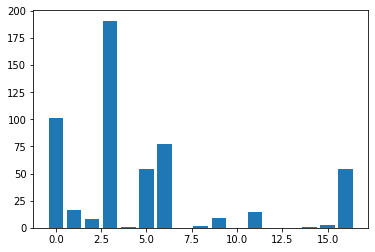

In [64]:
u, counts = np.unique(y_pred, return_counts=True)
plt.bar(u, counts)

In [65]:
y_pred

array([ 6,  3,  6,  3,  3,  0,  3, 15,  3,  6,  3,  0,  3, 16, 11,  2,  0,
        3,  3, 16,  0, 16,  6,  3,  3,  3,  6,  5, 16,  3, 16,  6,  0,  0,
        0,  0,  0,  3,  3, 16,  0,  3,  5,  8,  0,  3,  3,  5,  3,  3,  3,
        3,  6,  3,  5,  0,  3,  0,  3,  3,  3,  3,  3,  3,  5,  6,  6,  5,
        1,  0,  6,  6,  3,  3,  5,  3,  0,  5, 16,  6, 16,  6,  6,  3, 16,
        3,  0, 11,  5,  6,  6,  3,  3,  2,  3,  1, 16,  9,  0,  0, 16,  0,
        3,  2,  5,  3, 11,  6,  3, 11,  0,  3,  0,  6,  6,  3,  0,  6,  3,
        6,  5,  3,  3,  3,  0,  6,  4,  3,  3,  0, 16,  0,  3,  0,  3,  5,
        5,  5,  6,  3,  0,  3,  3,  6,  9,  3,  0,  0,  0,  3,  0,  5, 16,
        5,  0,  3,  3,  0,  1,  3,  9,  3, 16,  3,  3,  3,  3, 11,  0,  5,
        6,  6,  0, 16, 14,  3, 16,  3,  3,  0,  6,  0, 11,  3,  3,  6,  3,
        6,  0,  3, 16,  9,  5,  6,  0,  3,  6,  6, 16, 16,  3,  3,  6,  3,
        3,  6,  3,  3,  0,  3,  6, 16,  0,  3,  6,  0,  3,  3, 16, 16,  0,
        0,  6,  0,  0,  0

In [66]:
label_author_map = dict([(v,k) for k,v in author_label_map.items()])

In [67]:
author_pred = list(map(label_author_map.get, y_pred))

In [68]:
data_test['predicted label'] = y_pred
data_test['predicted author'] = author_pred
data_test

,filename,tokens,predicted label,predicted author
0,54740.txt,"[９, 字, 下げ, 一, 一, は, 中, 見出し, 日本一, の, 面白い, 話, が,...",6,高村 光雲
1,56321.txt,"[５, 字, 下げ, 一, 一, は, 中, 見出し, 捕物, 小説, という, もの, を...",3,野村 胡堂
2,56201.txt,"[５, 字, 下げ, 一, 一, は, 中, 見出し, おや, 八, 五, 郎, 親分, も...",6,高村 光雲
3,51417.txt,"[先刻, 御, 面, 遠い, 遠い, に, 倒, の, 注記, 御, 頼, 申, 上, 候,...",3,野村 胡堂
4,49540.txt,"[何, と, いう, て, も, この, 頃, は, 読書, 子, に, 取る, て, は,...",3,野村 胡堂
...,...,...,...,...
527,476.txt,"[一, 次郎左衛門, じ, ろ, ざえもん, が, 野, 州, や, しゅう, 佐野, の,...",16,中谷 宇吉郎
528,57308.txt,"[今年, の, 六月, 本土, 爆撃, が, いよいよ, 苛烈, に, なる, て, 東京,...",0,折口 信夫
529,1710.txt,"[序, 思想, という, もの, は, その, 持ち主, の, 身, に, つく, ば, そ...",3,野村 胡堂
530,53489.txt,"[もう, 十, 年, 以上, も, 前, の, こと, だ, ある, が, まだ, 私, が...",1,種田 山頭火


In [101]:
filename_author_map.get('49541.txt')

'岡本 綺堂'

In [98]:
testfilename_author_map = dict(zip(data_test['filename'], data_test['predicted author']))

In [94]:
testfilename_author_map.get('56319.txt')

In [142]:
# TODO: align filenames

import pandas as pd


input_test='./aozora_datasets_min/test_author_novel.csv'
df_test = pd.read_csv(input_test)
df_test

,novel_id,filename
0,2198,2198.txt
1,2213,2213.txt
2,2627,2627.txt
3,2618,2618.txt
4,2621,2621.txt
...,...,...
527,48367,48367.txt
528,48163,48163.txt
529,48151,48151.txt
530,48152,48152.txt


In [147]:
df_test['author'] = list(map(testfilename_author_map.get, df_test['filename']))

In [149]:
df_test.head(30)

,novel_id,filename,author
0,2198,2198.txt,戸坂 潤
1,2213,2213.txt,戸坂 潤
2,2627,2627.txt,石川 啄木
3,2618,2618.txt,正岡 子規
4,2621,2621.txt,野村 胡堂
5,3409,3409.txt,野村 胡堂
6,2620,2620.txt,戸坂 潤
7,2216,2216.txt,戸坂 潤
8,2221,2221.txt,野村 胡堂
9,2630,2630.txt,野村 胡堂


In [145]:
output_test='./aozora_datasets_min/test_author_novel_predicted.csv'
df_test.to_csv(output_test)

In [146]:
label_author_map

{0: '折口 信夫',
 1: '種田 山頭火',
 2: '木暮 理太郎',
 3: '野村 胡堂',
 4: '江戸川 乱歩',
 5: '戸坂 潤',
 6: '高村 光雲',
 7: '久生 十蘭',
 8: '石川 啄木',
 9: '坂本 竜馬',
 10: '紫式部 ',
 11: '正岡 子規',
 12: '泉 鏡花',
 13: '若山 牧水',
 14: '岡本 綺堂',
 15: '吉川 英治',
 16: '中谷 宇吉郎'}